# Adjoint Method

This page provides an overview of the adjoint method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## The True Function

The true function $\textbf{x}^t(t)$ represents the real physics process that the model is trying to capture. For the ocean model example, this function yields 3D fields of temperature, salinity, velocity, and other other parameters pertinent to the ocean. 

In the example for this notebook, $\textbf{x}^t(t)$ is a one-dimensional function representing the height of a ball thrown from a platform with an initial height of $h_0 = 3$ m, an initial velocity of $v_0 = 15$ m/s, and on a planet with a gravitational acceleration of $g=-9.8$ m/s$^2$. Friction in the air is neglected for this example. From physics and calculus, this function has a simple, quadratic form:

$$
x^t(t) = h_0 + v_0t + \frac{g}{2}t^2
$$

We can define this function for computations as follows:

In [2]:
# define the true constants
h_0_t = 3
v_0_t = 15
g_t = -9.8

# define the time
delta_t = 0.01
t_max = (-v_0_t - np.sqrt(v_0_t**2-2*g_t*h_0_t))/g_t
t = np.arange(0,t_max,delta_t)

# define the true solution 
x_true = h_0_t + v_0_t*t + g_t/2*(t**2)
v_true = v_0_t + g_t*t

In the optimization problem, a model $M$ is optimized to best fit a set of observational data $\textbf{y}^O$ which is a function of the true solution. In the ocean, $\textbf{y}^O$ may correspond to data from satellites or in situ observations. The mapping from the true physical space to the data $H$ can be expressed as

$$
\textbf{y}^O = H \begin{bmatrix} \textbf{x}^t(t_0)\\ \vdots \\ \textbf{x}^t(t_N)  \end{bmatrix} + \boldsymbol\varepsilon
$$

where $\boldsymbol\varepsilon$ are the errors associated with the measurements. The errors are assumed to have zero mean and covariance matrix $\textbf{R}$. 

For our projectile example, we can assume that we are able to make observations of our projectile at times $t=0.5$ seconds and $t=2$ seconds. At each of these times, we can observe both the position $x$ and the velocity $v$ of the projectile. In this case, we can organize our measurements into a data array as

$$
\textbf{y}^O = \begin{bmatrix} x(t=0.5)\\ x(t=2)\\ v(t=0.5)\\ v(t=2)  \end{bmatrix}
$$

We can define this measurement function as follows:

In [3]:
def H(t, v, x):
    data = np.zeros((4,))

    # two times
    t_0 = np.argmin(np.abs(t-0.5))
    t_1 = np.argmin(np.abs(t-2))
    
    # two position measurements
    data[0] = x[t_0]
    data[1] = x[t_1]
    
    # two velocity measurements
    data[2] = v[t_0]
    data[3] = v[t_1]

    return(data)

Then, the measurement data can then be computed with our function:

In [4]:
y_O = H(t, v_true, x_true)

# uncertainties
x_sigma = 1
v_sigma = 2

# these lines can be used to add some error to the data, if interested
np.random.seed(9) # seed for reproducibility
# y_O[0] += np.random.normal(0,x_sigma)
# y_O[1] += np.random.normal(0,x_sigma)
# y_O[2] += np.random.normal(0,v_sigma)
# y_O[3] += np.random.normal(0,v_sigma)

print('The observational data is: ', y_O)

The observational data is:  [ 9.275 13.4   10.1   -4.6  ]


We can visualize the solution and our sampled data as follows:

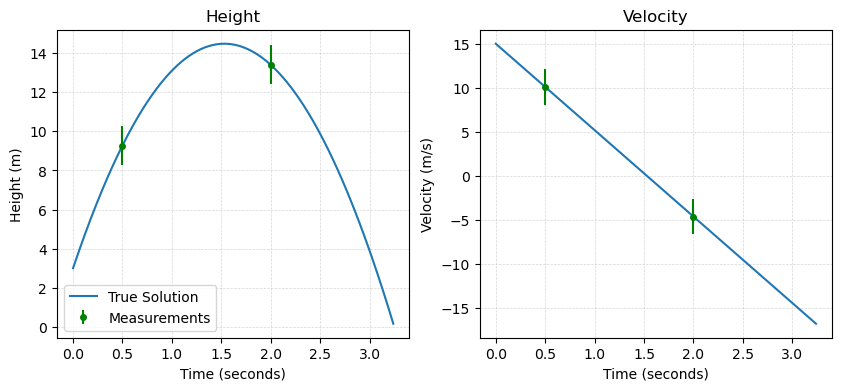

In [5]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(t, x_true, label='True Solution')
plt.errorbar(0.5, y_O[0], yerr=x_sigma, fmt='.', color='green', label='Measurements', markersize=8)
plt.errorbar(2, y_O[1], yerr=x_sigma, fmt='.', color='green', markersize=8)
plt.title('Height')
plt.legend()
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Height (m)')

plt.subplot(1,2,2)
plt.plot(t, v_true)
plt.errorbar(0.5, y_O[2], yerr=v_sigma, fmt='.', color='green', markersize=8)
plt.errorbar(2, y_O[3], yerr=v_sigma, fmt='.', color='green', markersize=8)
plt.title('Velocity')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (m/s)')

plt.show()

### The Modeled Solution
Ocean models are used to estimate the true function $\textbf{x}^t(t)$ with an estimated function is $\textbf{x}^f(t)$ using a model timestepping scheme $M_i$ such that

$$
\textbf{x}^f(t_{i+1}) = M_i[\textbf{x}^f(t_i)]
$$

For the projectile example, we can write this explicitly as

$$
\begin{align*}
x^f(t_{i+1}) = M_i[x^f(t_{i})] &= x^f(t_i) + v^f(t_i)\Delta t \\
v^f(t_{i+1}) = M_i[v^f(t_{i})] &= v^f(t_i) +g \Delta t
\end{align*}
$$

where the first line is the position of the projectile and the second represents the velocity.

For the projectile, we can define the model $M$ in terms of the initial conditions $h_0$ and $v_0$ and the gravity parameter $g$ as follows:

In [6]:
def M(t, delta_t, h_0, v_0, g, y_O):
    # compute the number of timesteps
    n_timesteps = np.size(t)
    
    # make empty arrays to store the solution
    x = np.zeros((n_timesteps,))
    v = np.zeros((n_timesteps,))
    
    # start the solutions with the initial conditions
    x[0] = h_0
    v[0] = v_0
    
    # loop through the entire time array
    for i in range(n_timesteps-1):
        
        # estimate the next velocity
        v[i+1] = v[i] + g * delta_t
    
        # estimate the next position
        x[i+1] = x[i] + (v[i+1]+v[i])/2*delta_t

    # compute the cost function
    y = H(t, v, x)
    J = np.sqrt(np.sum((y-y_O)**2))

    return(v, x, J)

### Visualizing the Solution
To visualize how the function above is utilized, consider a scenario where we have some preliminary guesses for $h_0$, $v_0$ and $g$ which differ from the true values. We can construct this model solution using our function as follows:

In [7]:
# model parameters - first guess
h_0 = 2
v_0 = 17
g = -10

# define a time for the model
delta_t_model = 0.1
t_model = np.arange(0,t_max,delta_t_model)

# compute an estimated solution
v_estimated, x_estimated, cost = M(t_model, delta_t_model, h_0, v_0, g, y_O)

# print cost
print(cost)

3.595917824422579


Next, we compare our preliminary solution with the true solution:

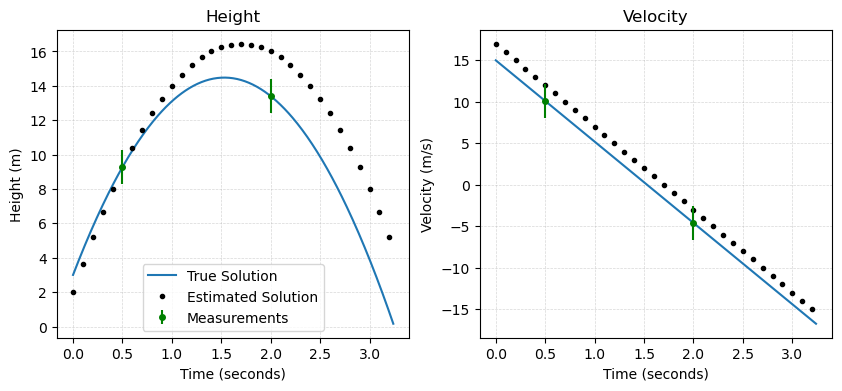

In [8]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(t, x_true, label='True Solution')
plt.plot(t_model, x_estimated, 'k.', label='Estimated Solution')
plt.errorbar(0.5, y_O[0], yerr=x_sigma, fmt='.', color='green', label='Measurements', markersize=8)
plt.errorbar(2, y_O[1], yerr=x_sigma, fmt='.', color='green', markersize=8)
plt.title('Height')
plt.legend()
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Height (m)')

plt.subplot(1,2,2)
plt.plot(t, v_true)
plt.plot(t_model, v_estimated, 'k.', label='Estimated Solution')
plt.errorbar(0.5, y_O[2], yerr=v_sigma, fmt='.', color='green', markersize=8)
plt.errorbar(2, y_O[3], yerr=v_sigma, fmt='.', color='green', markersize=8)
plt.title('Velocity')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (m/s)')

plt.show()

As we can see in the plots above, our model solution clearly differs from the true solution. More importantly, our model solution different from the measurements made of the projectile in both position and velocity. 

The data-model differences $\textbf{y}^d$ can be computed with the same measurement function defined above where here, we now pass in the estimated model parameters:

In [9]:
y = H(t_model, v_estimated, x_estimated)
y_d = y_O - y
print('Model errors:',y_d)

Model errors: [ 0.025 -2.6   -1.9   -1.6  ]


### Assessing the sensivity of the model to parameter perturbations

In [10]:
# epsilon
eps = 0.01

# test 1
_, _, c_0f = M(t_model, delta_t_model, h_0+eps, v_0, g, y_O)
_, _, c_0b = M(t_model, delta_t_model, h_0-eps, v_0, g, y_O)
g_0 = (c_0f - c_0b)/(2*eps)

# test 2
_, _, c_1f = M(t_model, delta_t_model, h_0, v_0+eps, g, y_O)
_, _, c_1b = M(t_model, delta_t_model, h_0, v_0-eps, g, y_O)
g_1 = (c_1f - c_1b)/(2*eps)

# test 3
_, _, c_2f = M(t_model, delta_t_model, h_0, v_0, g+eps, y_O)
_, _, c_2b = M(t_model, delta_t_model, h_0, v_0, g-eps, y_O)
g_2 = (c_2f - c_2b)/(2*eps)

print(g_0, g_1, g_2)

0.7160856609133459 2.415930102120112 2.599286442535731


### Forward Linear

In [11]:
def M_FL(t, delta_t, h_0, v_0, g, y_O, perturb='h_0'):
    # compute the number of timesteps
    n_timesteps = np.size(t)
    
    # make empty arrays to store the solution
    x = np.zeros((n_timesteps,))
    v = np.zeros((n_timesteps,))
    
    # start the solutions with the initial conditions
    x[0] = h_0
    v[0] = v_0
    
    # loop through the entire time array
    for i in range(n_timesteps-1):
        
        # estimate the next velocity
        v[i+1] = v[i] + g * delta_t
    
        # estimate the next position
        x[i+1] = x[i] + (v[i+1]+v[i])/2*delta_t

    # compute the cost function
    y = H(t, v, x)
    J = np.sqrt(np.sum((y-y_O)**2))
    Jd = 

    return(v, x, J)

SyntaxError: invalid syntax (2045607225.py, line 25)

### Optimizing the model parameters

Gradient descent

In [20]:
def compute_cost_gradient(t, delta_t, h_0, v_0, g, y_O):
    # epsilon
    eps = 0.01
    
    # test 1
    _, _, c_0f = M(t, delta_t, h_0+eps, v_0, g, y_O)
    _, _, c_0b = M(t, delta_t, h_0-eps, v_0, g, y_O)
    g_0 = (c_0f - c_0b)/(2*eps)
    
    # test 2
    _, _, c_1f = M(t_model, delta_t, h_0, v_0+eps, g, y_O)
    _, _, c_1b = M(t_model, delta_t, h_0, v_0-eps, g, y_O)
    g_1 = (c_1f - c_1b)/(2*eps)
    
    # test 3
    _, _, c_2f = M(t, delta_t, h_0, v_0, g+eps, y_O)
    _, _, c_2b = M(t, delta_t, h_0, v_0, g-eps, y_O)
    g_2 = (c_2f - c_2b)/(2*eps)
    
    return(g_0, g_1, g_2)

The matrix $\textbf{G}$ is:

In [54]:
# model parameters - first guess
h_0 = 2
v_0 = 17
g = -10

esp = 0.1
for i in range(1000):
    v, x, cost = M(t_model, delta_t_model, h_0, v_0, g, y_O)
    
    gradient = compute_cost_gradient(t, delta_t, h_0, v_0, g, y_O)
    if i%10==0:
        print(cost, gradient)
    h_0 -= eps*gradient[0]
    v_0 -= eps*gradient[1]
    g -= eps*gradient[2]

# store the optimized parameters
h_0_opt = h_0
v_0_opt = v_0
g_opt = g

3.595917824422579 (np.float64(0.7160856609135458), np.float64(1.040424794496353), np.float64(2.599286442533))
2.6668144091133774 (np.float64(0.616226922220986), np.float64(1.032603461985282), np.float64(2.4124004249289177))
1.906791250913185 (np.float64(0.4198281084963784), np.float64(1.025309859629786), np.float64(1.9849367207818824))
1.4424646741988407 (np.float64(0.09603165517638734), np.float64(1.0191568214008129), np.float64(1.1732032455935681))
1.2621100390706605 (np.float64(-0.2126604353398398), np.float64(1.0145910738675212), np.float64(0.31822758875645896))
1.191052340580848 (np.float64(-0.3966470221201557), np.float64(1.0112598821654828), np.float64(-0.20477588404503866))
1.1338269806347216 (np.float64(-0.4970710842742254), np.float64(1.0086169567456338), np.float64(-0.4688333277667267))
1.0706923152502341 (np.float64(-0.5572785974102046), np.float64(1.0063455369278884), np.float64(-0.5970693383008485))
1.0012656128618953 (np.float64(-0.5984753702428292), np.float64(1.0042916

This vector contains the perturbations for each of the parameters in the perturbation experiments and can be used to find the optimized model parameters, i.e.

In [51]:
print('After the optimization, the parameters are as follows:')
print('    h_0: '+'{:.4f}'.format(h_0_opt)+' m')
print('    v_0: '+'{:.4f}'.format(v_0_opt)+' m/s')
print('    g: '+'{:.4f}'.format(g_opt)+' m/s^2')

After the optimization, the parameters are as follows:
    h_0: 5.9593 m
    v_0: 8.3911 m/s
    g: -5.5728 m/s^2


With these new parameters, the optimized model can be computed and compared with the true solution:

In [52]:
# compute the optimized model
v_opt, x_opt, _ = M(t_model, delta_t_model, h_0_opt, v_0_opt, g_opt, y_O)

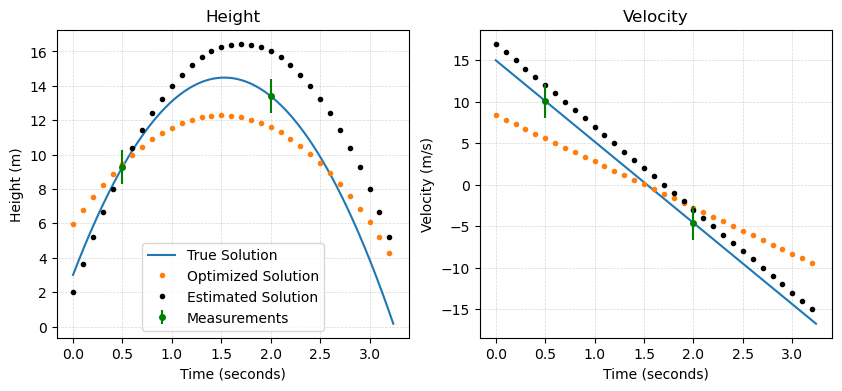

In [53]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(t, x_true, label='True Solution')
plt.plot(t_model, x_opt, '.',label='Optimized Solution')
plt.plot(t_model, x_estimated, 'k.', label='Estimated Solution')
plt.errorbar(0.5, y_O[0], yerr=x_sigma, fmt='.', color='green', label='Measurements', markersize=8)
plt.errorbar(2, y_O[1], yerr=x_sigma, fmt='.', color='green', markersize=8)
plt.title('Height')
plt.legend()
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Height (m)')

plt.subplot(1,2,2)
plt.plot(t, v_true)
plt.plot(t_model, v_opt, '.', label='Optimized Solution')
plt.plot(t_model, v_estimated, 'k.', label='Estimated Solution')
plt.errorbar(0.5, y_O[2], yerr=v_sigma, fmt='.', color='green', markersize=8)
plt.errorbar(2, y_O[3], yerr=v_sigma, fmt='.', color='green', markersize=8)
plt.title('Velocity')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (m/s)')

plt.show()

As we can see from this comparison, the solution is much closer to the true solution with the optimized parameters!

### Green's Functions in an Iterative Process

As we saw in the example above, the optimized parameters provided an set of parameters that yielded an improved fit to observation. However, the model did not perfectly reproduce the true solution.

This approach can also be used in an iterative process to provide further improvements in the parameters. Begin by defining a function to run the Green's function approach above that can be leveraged in an iterative process:

In [20]:
def Greens_function_optimization(t_model, v_estimated, x_estimated):
    # compute model data differences
    data = H(t_model, v_estimated, x_estimated)
    y_d = y_O - data

    # define some perturbations
    # np.random.seed(3)
    e_0 = np.random.normal(0,1)
    e_1 = np.random.normal(0,1)
    e_2 = np.random.normal(0,1)
    
    # run the perturbation experiments
    v_est_0, x_est_0 = M(t_model, delta_t_model, h_0+e_0, v_0, g)
    v_est_1, x_est_1 = M(t_model, delta_t_model, h_0, v_0+e_1, g)
    v_est_2, x_est_2 = M(t_model, delta_t_model, h_0, v_0, g+e_2)
    
    # sample the perturbation experiments at the data locations
    data_0 = H(t_model, v_est_0, x_est_0)
    data_1 = H(t_model, v_est_1, x_est_1)
    data_2 = H(t_model, v_est_2, x_est_2)

    # compute the G matrix
    g0 = (data_0 - data)/e_0
    g1 = (data_1 - data)/e_1
    g2 = (data_2 - data)/e_2
    G = np.column_stack([g0, g1, g2])

    # solve for the parameters
    P = np.linalg.inv(np.linalg.inv(Q) + np.transpose(G) @ np.linalg.inv(R) @ G)
    eta_soln = P@np.transpose(G)@np.linalg.inv(R)@y_d
    return(eta_soln)

Note that in the above function, the perturbations to the parameters are done stochastically rather that prescribed as in the example above.

Next, we can define a loop to run this process iteratively:

In [21]:
# define the first-guess parameters and model solution
h_0 = 2
v_0 = 17
g = -10
v, x = M(t_model, delta_t_model, h_0, v_0, g)

# run the Green's function approximation many times
iterations = 100
for i in range(iterations):
    eta_a = Greens_function_optimization(t_model, v, x)
    h_0 += eta_a[0]
    v_0 += eta_a[1]
    g += eta_a[2]
    v, x = M(t_model, delta_t_model, h_0, v_0, g)

print('After '+str(iterations)+' iterations, the optimized parameters are:')
print('    h_0: '+'{:.4f}'.format(h_0)+' m')
print('    v_0: '+'{:.4f}'.format(v_0)+' m/s')
print('    g: '+'{:.4f}'.format(g)+' m/s^2')

After 100 iterations, the optimized parameters are:
    h_0: 3.0000 m
    v_0: 15.0000 m/s
    g: -9.8000 m/s^2


As we can see, applying the process many times over yields a convergence in the parameters to the true solution. This is attainable because the data was sampled exactly from the true solution.